In [1]:
import os
import tensorflow as tf
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from tensorflow import keras

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

dataset = pd.read_csv('D:/Kaggle/driver_imgs_list.csv')
print(dataset.head(5))
# tf.config.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [2]:
NUMBER_CLASSES = 10 # 10 classes
activity_map = {'c0': 'Safe driving',
                'c1': 'Texting - right',
                'c2': 'Talking on the phone - right',
                'c3': 'Texting - left',
                'c4': 'Talking on the phone - left',
                'c5': 'Operating the radio',
                'c6': 'Drinking',
                'c7': 'Reaching behind',
                'c8': 'Hair and makeup',
                'c9': 'Talking to passenger'}

In [3]:
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    """
    Function that return an opencv image from the path and the right number of dimension
    """
    if color_type == 1: # Loading as Grayscale image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3: # Loading as color image
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    return img

# Loading Training dataset
def load_train(img_rows, img_cols, color_type=3):
    """
    Return train images and train labels from the original path
    """
    train_images = []
    train_labels = []
    # Loop over the training folder
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('D:/Kaggle/imgs/train/c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    return train_images, train_labels


def read_and_normalize_train_data(img_rows, img_cols, color_type):
    """
    Load + categorical + split
    """
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)  # categorical train label
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=42)  # split into train and test
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1, img_rows, img_cols, color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1, img_rows, img_cols, color_type)

    return x_train, x_test, y_train, y_test

# Loading validation dataset
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    """
    Same as above but for validation dataset
    """
    path = os.path.join('D:/Kaggle/imgs/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids

In [4]:
img_rows = 64 # dimension of images
img_cols = 64
color_type = 1 # grey
nb_test_samples = 200

# loading train images
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

# loading validation images
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:08<01:17,  8.57s/it]

Loading directory c1


 20%|██        | 2/10 [00:16<01:05,  8.14s/it]

Loading directory c2


 20%|██        | 2/10 [00:23<01:33, 11.75s/it]


KeyboardInterrupt: 

In [ ]:
# Number of batch size and epochs
batch_size = 40 #40
nb_epoch = 6 #10

In [ ]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5',
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
def create_model():
    model = Sequential()

    # Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

    # Dropout is a technique used to prevent a model from overfitting by randomly disabling neurons and their corresponding connections. This prevents the network from relying too much on single neurons and forces all neurons to learn to generalize better.

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [ ]:
from keras.utils.vis_utils import plot_model

model = create_model()

# More details about the layers
model.summary()
# plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

# Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

#model.load_weights('saved_models/weights_best_vanilla.hdf5')
print('History of the training',history.history)

In [ ]:
def plot_train_history(history):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_train_history(history)

In [ ]:
score1 = model.evaluate(x_test, y_test, verbose=1)

In [ ]:
def plot_test_class(model, test_files, image_number, color_type=1):
    """
    Function that tests or model on test images and show the results
    """
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))

    plt.show()

In [ ]:
for i in range(10):
    plot_test_class(model, test_files, i+50)

In [61]:
# Using ImageDataGenerator from keras
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [62]:
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

In [63]:
history_v2 = model.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = nb_epoch,
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Epoch 1/6
448/448 [==============================] - 119s 264ms/step - loss: 1.2088 - accuracy: 0.6427 - val_loss: 15.9842 - val_accuracy: 0.1069
Epoch 2/6
448/448 [==============================] - 117s 262ms/step - loss: 0.6353 - accuracy: 0.7945 - val_loss: 0.4423 - val_accuracy: 0.8804
Epoch 3/6
448/448 [==============================] - 120s 268ms/step - loss: 0.5036 - accuracy: 0.8387 - val_loss: 0.1044 - val_accuracy: 0.9763
Epoch 4/6
448/448 [==============================] - 121s 269ms/step - loss: 0.4353 - accuracy: 0.8643 - val_loss: 0.1459 - val_accuracy: 0.9598
Epoch 5/6
448/448 [==============================] - 119s 266ms/step - loss: 0.3771 - accuracy: 0.8800 - val_loss: 0.0952 - val_accuracy: 0.9743
Epoch 6/6
448/448 [==============================] - 122s 271ms/step - loss: 0.3440 - accuracy: 0.8958 - val_loss: 0.1068 - val_accuracy: 0.9786


In [64]:
def plot_test_class_aug(model, test_files, image_number, color_type=1):
    """
    Function that tests or model on test images and show the results
    """
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict_generator(test_generator, steps=nb_validation_samples // batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))

    plt.show()

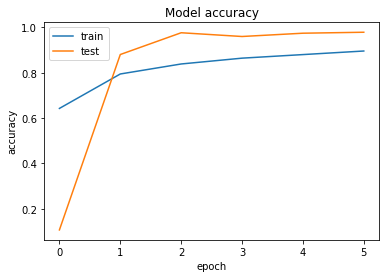

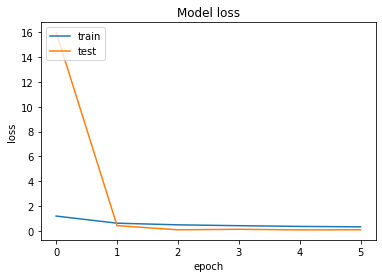

In [68]:
#model2.load_weights('saved_models/weights_best_va nilla.hdf5')
plot_train_history(history_v2)

In [71]:
# Evaluate and compare the performance of the new model
score2 = model.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print("Loss for model 1",score1[0])
print("Loss for model 2 (data augmentation):", score2[0])

print("Test accuracy for model 1",score1[1])
print("Test accuracy for model 2 (data augmentation):", score2[1])

Loss for model 1 6953.79296875
Loss for model 2 (data augmentation): 0.10681800544261932
Test accuracy for model 1 0.17770345509052277
Test accuracy for model 2 (data augmentation): 0.9785714149475098


1/1 [==============================] - 0s 19ms/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


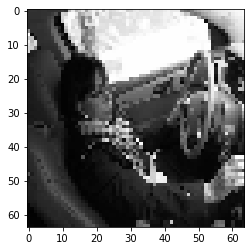

1/1 [==============================] - 0s 17ms/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


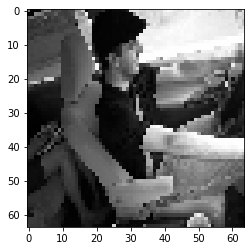

1/1 [==============================] - 0s 19ms/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


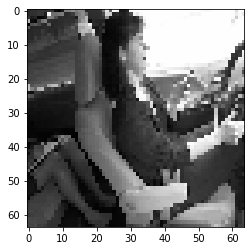

1/1 [==============================] - 0s 17ms/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


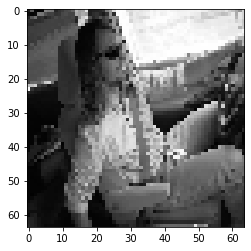

1/1 [==============================] - 0s 18ms/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


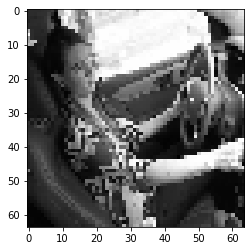

1/1 [==============================] - 0s 18ms/step
Y prediction: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted: Hair and makeup


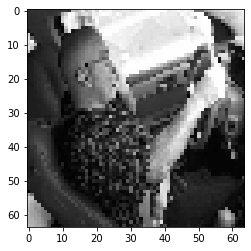

1/1 [==============================] - 0s 21ms/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


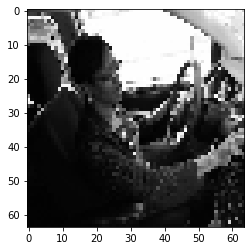

1/1 [==============================] - 0s 17ms/step
Y prediction: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted: Hair and makeup


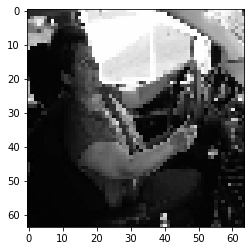

1/1 [==============================] - 0s 20ms/step
Y prediction: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted: Hair and makeup


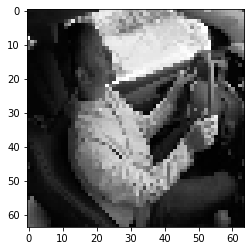

1/1 [==============================] - 0s 21ms/step
Y prediction: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted: Hair and makeup


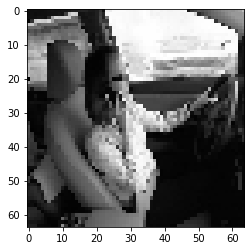

In [66]:
for i in range(10):
    plot_test_class(model, test_files, i*i)

In [24]:
# model.save("saved_models/Finalized model(3-CNN) no aug")

INFO:tensorflow:Assets written to: saved_models/Finalized model(3-CNN) no aug\assets


In [58]:
def prepare(filepath, model):

    img_brute = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))

    plt.show()

    # img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    # new_array = cv2.resize(img_array, (img_rows, img_cols))
    # return new_array.reshape(-1, img_rows, img_cols, 1)

In [55]:
loaded_model = tf.keras.models.load_model("saved_models/Finalized model(3-CNN)")

In [56]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                        

1/1 [==============================] - 0s 17ms/step
Y prediction: [[6.6565666e-03 8.4647356e-04 2.7897356e-02 4.3623036e-04 3.1534688e-05
  4.4585622e-08 1.7015354e-07 9.6219087e-01 1.7018884e-03 2.3885231e-04]]
Predicted: Reaching behind


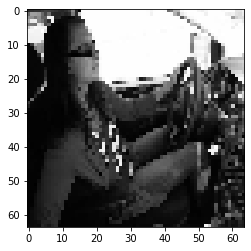

1/1 [==============================] - 0s 19ms/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


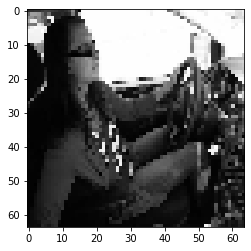

In [60]:
prepare('./imgTesting/img_202.jpg', model)
prepare('./imgTesting/img_202.jpg', loaded_model)